# Lab05

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Ejercicio 01

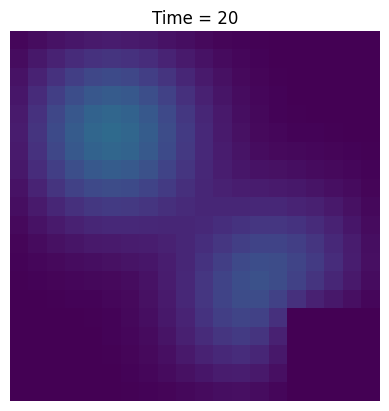

In [43]:
def initialize_grid(M, N, restricted_areas):
    """
    Initialize the grid and set restricted areas.
    
    Args:
    - M: Number of rows in the grid.
    - N: Number of columns in the grid.
    - restricted_areas: List of restricted areas, where each area is defined by
      a tuple (x_start, y_start, x_end, y_end), representing the top-left and bottom-right corners.

    Returns:
    - grid: The grid with ones (1) for allowed areas and zeros (0) for restricted areas.
    """
    grid = np.ones((M, N))
    
    # Apply each restricted area (set to 0)
    for (x_start, y_start, x_end, y_end) in restricted_areas:
        grid[x_start:x_end, y_start:y_end] = 0
    
    return grid

def generate_gaussian_spots(u0, grid, M, N, centers, max_radius, sigma):
    """
    Generate Gaussian-like spots on the grid, avoiding restricted areas, at specific center locations.
    
    centers: A list of tuples representing the coordinates of the Gaussian centers.
    """
    # For each predefined center, generate a Gaussian-like spot
    for (x_center, y_center) in centers:
        # Ensure the center is within the valid area
        if grid[x_center, y_center] == 1:  # Only proceed if it's inside the valid area
            # For each spot, set a decaying value based on the distance from the center
            for i in range(M):
                for j in range(N):
                    # Calculate distance from the center
                    distance = np.sqrt((i - x_center)**2 + (j - y_center)**2)
                    if distance <= max_radius and grid[i, j] == 1:  # Inside the radius and valid region
                        # Use a Gaussian-like decay: higher at the center, lower at the edges
                        u0[i, j] = np.exp(-distance**2 / (2 * sigma**2))

    return u0

def diffusion_simulation(M, N, restricted_areas, T, K, u0):
    """
    Perform a diffusion simulation on the grid.
    """
    grid = initialize_grid(M, N, restricted_areas)
    u = u0.copy()  # Copy initial distribution

    # Store each step of the simulation for visualization
    frames = [u.copy()]

    # Neighborhood shifts for 8 neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    # For each time step
    for t in range(1, T + 1):
        new_u = u.copy()  # Copy current grid state
        for i in range(M):
            for j in range(N):
                if grid[i, j] == 1:  # Only update for cells in allowed areas
                    neighbor_sum = 0

                    # Calculate the sum of neighbors
                    for dx, dy in neighbors:
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < M and 0 <= nj < N and grid[ni, nj] == 1:
                            neighbor_sum += u[ni, nj]

                    # Update the cell using the diffusion equation
                    new_u[i, j] = (1 - K) * u[i, j] + (K / 8) * neighbor_sum
        
        u = new_u  # Update the state for the next time step
        frames.append(u.copy())  # Store frame for visualization
    
    return frames  # Return all frames for visualization

def visualize_diffusion(M, N, restricted_areas, T, K, u0):
    """
    Visualize the diffusion process using an animation.
    """
    # Run the simulation and get frames
    frames = diffusion_simulation(M, N, restricted_areas, T, K, u0)

    # Create a figure for plotting
    fig, ax = plt.subplots()

    # Use the 'viridis' colormap
    cmap = plt.get_cmap('viridis')

    # Update function for animation
    def update(t):
        ax.clear()
        cax = ax.imshow(frames[t], cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        ax.set_title(f'Time = {t}')
        plt.axis('off')

    # Create animation and assign it to a variable to prevent deletion
    ani = animation.FuncAnimation(fig, update, frames=range(T+1), repeat=False)

    # Save the animation as a GIF file
    ani.save('ejercicio01.gif', writer='pillow')

    # Show the animation
    plt.show()
    
    return ani

# Parameters
M, N = 20, 20  # Grid dimensions
restricted_areas = [(15, 15, 20, 20)]  # Define multiple restricted areas
T = 20  # Time steps
K = 0.5  # Diffusion speed parameter
u0 = np.zeros((M, N))  # Initialize the grid with zeros

# Initialize the grid with restricted areas
grid = initialize_grid(M, N, restricted_areas)

# Define specific centers for Gaussian spots
centers = [(5, 5), (14, 14)]  # Predefined centers for Gaussian spots

# Generate Gaussian-like spots, avoiding restricted areas, with specific center locations
u0 = generate_gaussian_spots(u0, grid, M, N, centers, max_radius=5, sigma=2)

# Visualize the diffusion process and assign the animation to a variable
visualize_diffusion(M, N, restricted_areas, T, K, u0)



### Ejercicio 02

C:\Users\bcarr\AppData\Local\Temp\ipykernel_6596\1870488203.py:99: RuntimeWarning: invalid value encountered in divide
  avg_pob[tt] /= np.sum(avg_pob[tt])


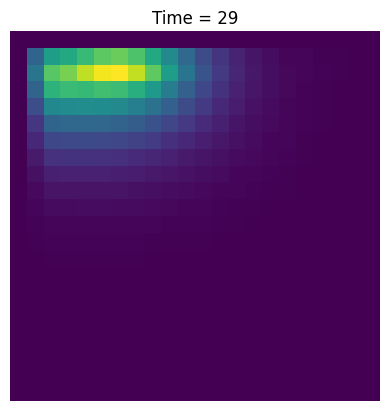

In [47]:
def diffusion_simulation(G0, restricted_areas, N, t, rad=1, K=1.0): 
    """
    Simulate particle diffusion over time with restricted areas.
    
    G0: Initial grid
    restricted_areas: Binary mask with 0s in restricted areas and 1s in allowed areas
    N: Number of particles
    t: Time steps
    rad: Neighborhood radius
    K: Probability of moving
    """
    S = G0.shape[0]
    Gext = np.pad(G0, rad)  # Extend the grid with padding
    restricted_ext = np.pad(restricted_areas, rad)  # Extend the restricted areas with padding

    # Initial distribution (particles are placed only in allowed areas)
    idx = np.argwhere((Gext > 0) & (restricted_ext == 1))  # Only allowed areas
    p = np.zeros(len(idx))
    for k in range(0, len(idx)):
        i, j = idx[k]
        p[k] = Gext[i, j]
    q = p.cumsum()

    # Initialize particles
    pos = np.zeros((N, 2)).astype(int)
    P0 = np.zeros((S+2, S+2)).astype(int)
    for l in range(0, N):
        r = np.random.rand()
        k = np.argwhere(q >= r).ravel().min()
        i, j = idx[k]
        pos[l, :] = [i, j]
        P0[i, j] += 1

    # Iterate over time steps
    pob = np.zeros((len(t), S+2, S+2)).astype(int)
    q_thresholds = np.array([0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0])  # Prob thresholds for movement
    
    for tt in range(1, len(t)):
        for k in range(1, N):
            [i, j] = pos[k, :]

            # Only move if inside bounds and allowed area
            if (i >= 1) & (i <= S) & (j >= 1) & (j <= S):
                r = np.random.rand()
                d = np.random.rand()
                if d < K:  # Probability check for movement
                    # Decide direction based on random number r
                    new_pos = [i, j]  # Default is staying in place
                    if r < q_thresholds[0] and restricted_ext[i+1, j] == 1:
                        new_pos = [i+1, j]
                    elif r < q_thresholds[1] and restricted_ext[i-1, j] == 1:
                        new_pos = [i-1, j]
                    elif r < q_thresholds[2] and restricted_ext[i, j+1] == 1:
                        new_pos = [i, j+1]
                    elif r < q_thresholds[3] and restricted_ext[i, j-1] == 1:
                        new_pos = [i, j-1]
                    elif r < q_thresholds[4] and restricted_ext[i+1, j+1] == 1:
                        new_pos = [i+1, j+1]
                    elif r < q_thresholds[5] and restricted_ext[i-1, j-1] == 1:
                        new_pos = [i-1, j-1]
                    elif r < q_thresholds[6] and restricted_ext[i+1, j-1] == 1:
                        new_pos = [i+1, j-1]
                    elif r < q_thresholds[7] and restricted_ext[i-1, j+1] == 1:
                        new_pos = [i-1, j+1]

                    pos[k, :] = new_pos
                    P0[new_pos[0], new_pos[1]] += 1
        
        # Store the positions for this time step
        pob[tt, :, :] = P0
    
    return pob

def average_experiments(G0, restricted_areas, N, t, rad=1, K=1.0, N_exp=10):
    """
    Run multiple experiments and return the average diffusion result.
    
    G0: Initial grid
    restricted_areas: Binary mask with 0s in restricted areas and 1s in allowed areas
    N: Number of particles
    t: Time steps
    rad: Neighborhood radius
    K: Probability of moving
    N_exp: Number of experiments
    """
    S = G0.shape[0]
    total_pob = np.zeros((len(t), S+2, S+2))  # To accumulate results over experiments

    # Run N_exp experiments
    for exp in range(N_exp):
        pob = diffusion_simulation(G0, restricted_areas, N, t, rad, K)  # Run a single diffusion simulation
        total_pob += pob  # Accumulate results

    # Average over the experiments
    avg_pob = total_pob / N_exp

    # Normalize by dividing by the total number of particles
    for tt in range(len(t)):
        avg_pob[tt] /= np.sum(avg_pob[tt])

    return avg_pob

def visualize_diffusion(pob, T):
    """
    Visualize the particle diffusion over time.
    
    pob: Particle positions over time
    T: Time steps
    """

    # Create a figure for plotting
    fig, ax = plt.subplots()

    # Use the 'viridis' colormap
    cmap = plt.get_cmap('viridis')

    # Update function for animation
    def update(t):
        ax.clear()
        cax = ax.imshow(pob[t], cmap=cmap, interpolation='nearest')
        ax.set_title(f'Time = {t}')
        plt.axis('off')

    # Create animation and assign it to a variable to prevent deletion
    ani = animation.FuncAnimation(fig, update, frames=range(1, T), repeat=False)

    # Save the animation as a GIF file
    ani.save('ejercicio02.gif', writer='pillow')

    # Show the animation
    plt.show()
    
    return ani

def gaussian_initial_distribution(M, N, centers, sigma):
    """
    Create a 2D Gaussian distribution with multiple centers on an MxN grid.
    
    M, N: Dimensions of the grid
    centers: A list of (center_x, center_y) tuples representing the coordinates of the Gaussian centers
    sigma: Standard deviation of the Gaussians (spread of each hotspot)
    """
    x, y = np.meshgrid(np.arange(0, N), np.arange(0, M))
    G0 = np.zeros((M, N))  # Initialize grid

    # Add a Gaussian for each center
    for (center_x, center_y) in centers:
        G0 += np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))
    
    return G0

# Define grid dimensions
M, N = 20, 20  # Grid dimensions

# Define restricted areas (1 for allowed, 0 for restricted)
restricted_areas = np.ones((M, N))
restricted_areas[15:, 15:] = 0  # Create a restricted area in the center

# Define Gaussian centers
centers = [(5,5),(15,15)]  # Multiple Gaussian centers
sigma = 2.0  # Spread of the Gaussians

# Create a Gaussian initial distribution with multiple centers
G0 = gaussian_initial_distribution(M, N, centers, sigma)

# Define simulation parameters
N_particles = 1000
T = 30
N_exp = 50  # Number of experiments
time_steps = np.arange(1, T+1)

# Simulate diffusion across multiple experiments with restricted areas
avg_pob = average_experiments(G0, restricted_areas, N_particles, time_steps, rad=1, K=1.0, N_exp=N_exp)

# Visualize the averaged diffusion
visualize_diffusion(avg_pob, T)



El método EDP ofrece una representación fluida del proceso de difusión. Modela el flujo exacto de la sustancia basándose en ecuaciones diferenciales y leyes físicas. En el método de partículas, el proceso de difusión se modela mediante el seguimiento de partículas individuales. En lugar de resolver una ecuación diferencial en un espacio continuo, simulamos el movimiento de partículas discretas que representan la sustancia que se difunde. Debido a que este método utiliza movimientos aleatorios, puede producir resultados ruidosos, siendo necesario promediar varios experimentos para reducir el ruido.

Si bien las partículas se alejan del centro, lo hacen de manera gradual y aleatoria. Dado que el proceso de difusión depende del movimiento aleatorio de cada partícula individual, lleva tiempo que suficientes partículas se alejen del centro para que el color cambie de manera notable. Como resultado, el recuento de partículas en el centro disminuye lentamente, lo que significa que el cambio de color (que se basa en el recuento de partículas) se retrasa en comparación con el enfoque EDP.
